# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
df_fights = pd.read_csv("data/data.csv")
df_fights["date"] = pd.to_datetime(df_fights["date"])
df_fights.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


# Analysis

In [4]:
sample_dates = ["2008-01-01", "2009-01-01", "2010-01-01", "2011-01-01", "2012-01-01", "2013-01-01", "2014-01-01"]

## Win loss draw rating

In [5]:
df_fighters = pd.concat([df_fights[["R_fighter", "date", "R_wins", "R_losses", "R_draw"]].rename(columns={
    "R_fighter":"fighter",
    "R_wins":"wins",
    "R_losses":"losses",
    "R_draw":"draw"}), df_fights[["B_fighter", "date", "B_wins", "B_losses", "B_draw"]].rename(columns={
    "B_fighter":"fighter",
    "B_wins":"wins",
    "B_losses":"losses",
    "B_draw":"draw"})]).sort_values(by="date").groupby("fighter").agg(["first", "last"]).reset_index()

df_fighters.head()

fighter       date             wins      losses       draw     
                       first       last first last  first last first last
0      Aalon Cruz 2020-02-29 2021-03-06     0    0      0    1     0    0
1     Aaron Brink 2000-11-17 2000-11-17     0    0      0    0     0    0
2  Aaron Phillips 2014-05-24 2020-07-15     0    0      0    2     0    0
3     Aaron Riley 2002-05-10 2013-07-27     0    3      0    5     0    0
4      Aaron Rosa 2011-06-11 2012-03-02     0    1      0    1     0    0

Text(0.5, 1.0, 'Evolution of the number of active fighters in UFC')

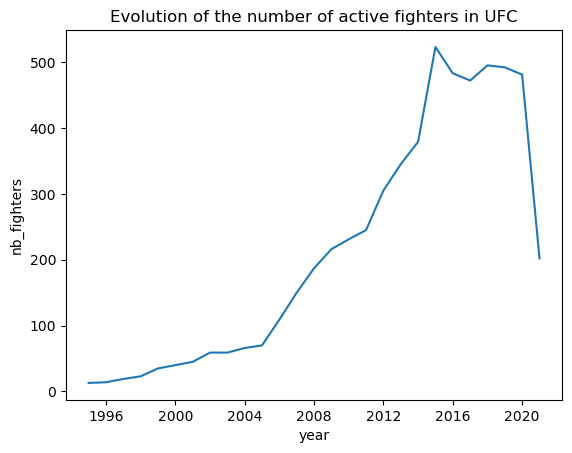

In [6]:
start, end = df_fighters["date", "first"].min(), df_fighters["date", "last"].max()
s_date_range = pd.Series(pd.date_range(start, end, freq="Y"))
plt.plot(s_date_range, s_date_range.apply(lambda u : ((df_fighters["date", "first"]<=u) 
                               & (df_fighters["date", "last"]>=u)
                               ).sum()))
plt.xlabel("year")
plt.ylabel("nb_fighters")
plt.title("Evolution of the number of active fighters in UFC")

In [7]:
def ranking_winLossDraw(w, l, d, alpha=0, offset=0):
    """simple ranking based on win/loss/draw informations.

    Args:
        w (int): number of wins
        l (int): number of losses
        d (int): number of draws
        alpha (int, optional): penalization term for the losses in [-1, +inf]. Close to -1 : . Defaults to 0.
        offset (int, optional): offset to avoid fighters with few matches to be extremely well rated. Defaults to 0.

    Returns:
        _type_: ranking between 0 and 1
    """
    return (w - alpha*l +.5*d - 0.5*alpha*d)/(w+l+d+offset)

def format_dataframeFighterRecord(fighter_corner):
    df = df_fights[[fighter_corner, "date", "Winner", "title_bout", "weight_class"]].copy()
    if fighter_corner == "R_fighter":
        condition_won = "Red"
        condition_lost = "Blue"
    elif fighter_corner == "B_fighter":
        condition_won = "Blue"
        condition_lost = "Red"
    
    df["won"] = df["Winner"].apply(lambda u: u == condition_won)
    df["lost"] = df["Winner"].apply(lambda u: u == condition_lost)
    df["draw"] = df["Winner"].apply(lambda u: u == "Draw")
    df = df.rename(columns={fighter_corner:"fighter"}).drop(columns="Winner")
    return df

df = pd.concat([format_dataframeFighterRecord("B_fighter"), format_dataframeFighterRecord("R_fighter")]).sort_values(by="date").reset_index(drop=True)
df_ratings = pd.merge(df, df.groupby("fighter")[["won", "lost", "draw"]].transform("cumsum").rename(columns={
                                                                                        "won":"won_total",
                                                                                        "lost":"lost_total",
                                                                                        "draw":"draw_total"}),
                                                                                                how="left", left_index=True, right_index=True)
df_ratings["n_fights"] = df_ratings["won_total"] + df_ratings["lost_total"] + df_ratings["draw_total"]
df_ratings["simple_ratings"] = df_ratings.apply(lambda u : ranking_winLossDraw(u["won_total"], u["lost_total"], u["draw_total"], alpha=1, offset=1), axis=1)
df_ratings

,fighter,date,title_bout,weight_class,won,lost,draw,won_total,lost_total,draw_total,n_fights,simple_ratings
0,Sean Daugherty,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
1,Remco Pardoel,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
2,Orlando Wiet,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
3,Johnny Rhodes,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
4,Fred Ettish,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
12019,Derek Brunson,2021-03-20,False,Middleweight,True,False,False,13,5,0,18,0.421053
12020,Montel Jackson,2021-03-20,False,Bantamweight,True,False,False,4,2,0,6,0.285714
12021,Bruno Silva,2021-03-20,False,Flyweight,True,False,False,1,2,1,4,-0.200000
12022,Trevin Giles,2021-03-20,False,Middleweight,True,False,False,5,2,0,7,0.375000


**A word on ranking by wins, losses and draws**\
The term $\frac{1}{2} d (1-\alpha)$ is introduced because we consider a draw to be half a win and half a loss.

Particuliar cases of the simple ranking:
- alpha = 0 (and offset = 0) : rating becomes win percentage
- alpha = -1 (and offset = 0) : rating becomes degenerate


However this simple ranking approach is not taking into account the strength of the opponent.

/home/pierrick/miniconda3/envs/authentic-performance/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


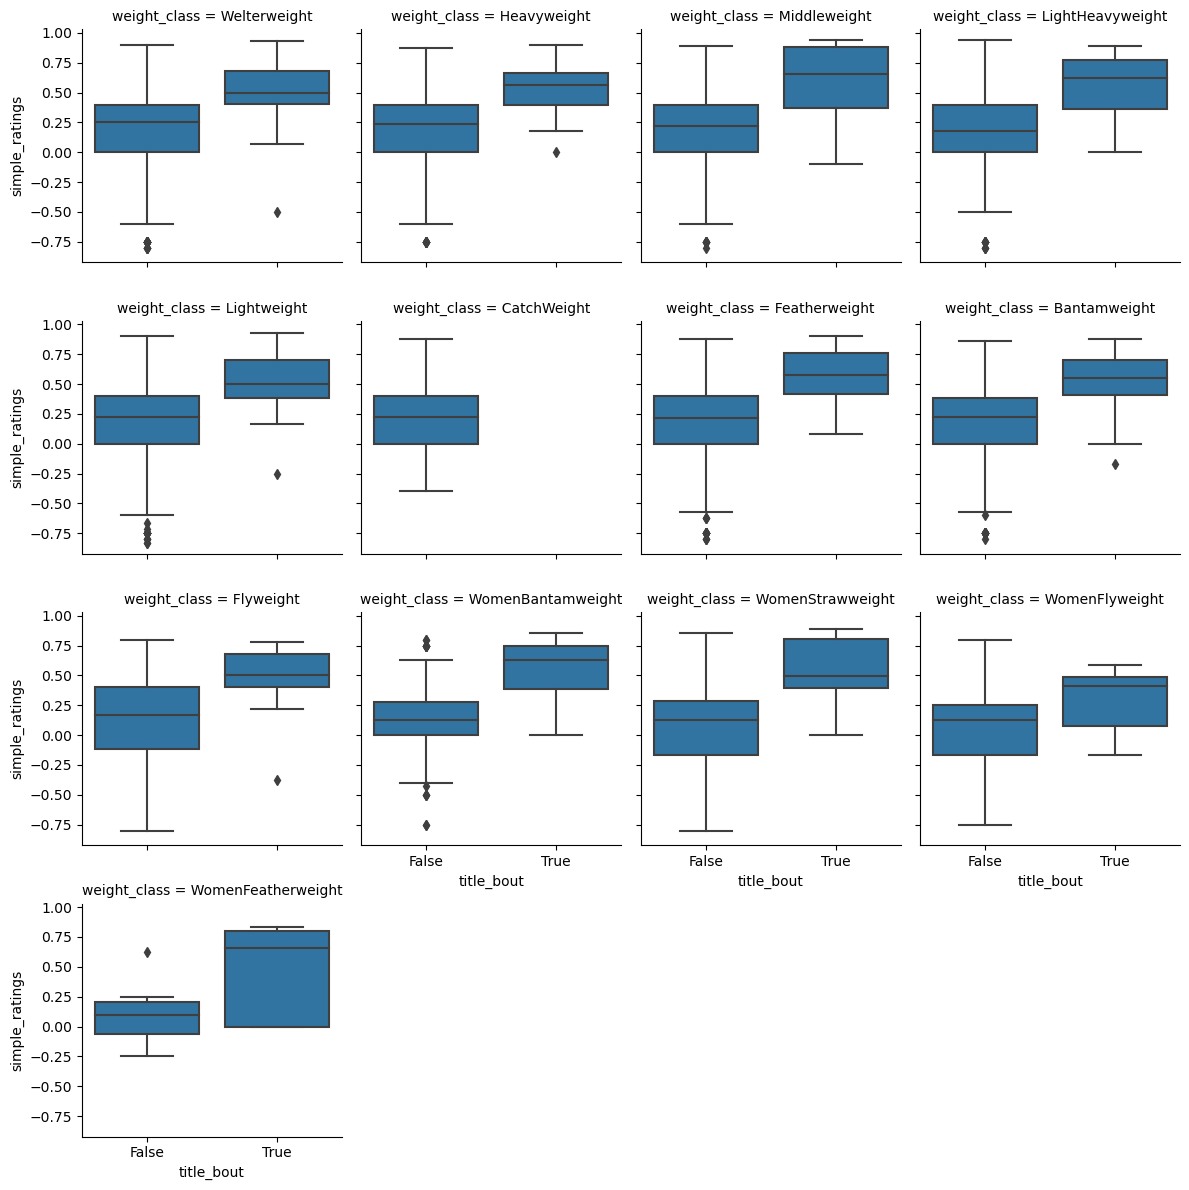

In [8]:
g = sns.FacetGrid(data = df_ratings[(df_ratings["n_fights"]>2)&(df_ratings["date"]>"2008")], col="weight_class", col_wrap=4)
g.map(sns.boxplot,"title_bout", "simple_ratings")

We can see that in all weight classes, fighters in a title bout tend to have higher ratings than fighters in regular fights.

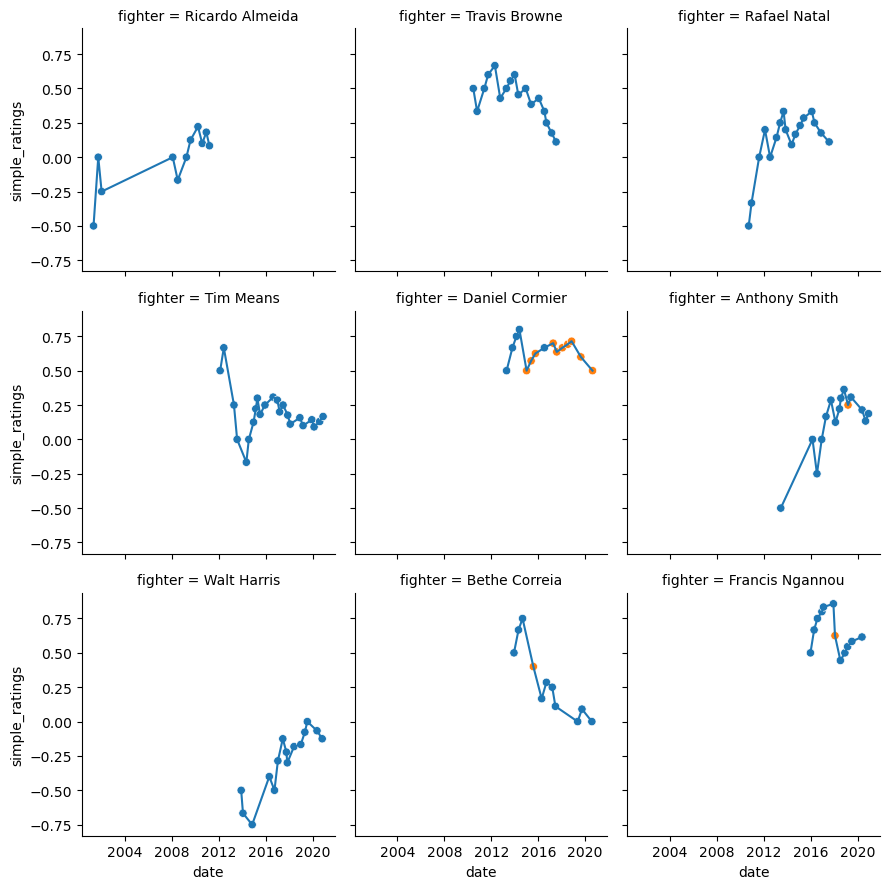

In [9]:
df = df_ratings.loc[df_ratings["fighter"].isin(np.random.choice(df_ratings.loc[df_ratings["n_fights"]>10,"fighter"].unique(), 9))]
g = sns.FacetGrid(data=df, col="fighter", col_wrap=3)
g.map(sns.lineplot,"date", "simple_ratings")
g.map(sns.scatterplot,"date", "simple_ratings", "title_bout")

In general title fights happen when the fighter is at a peak of rating

In [10]:
def convert_simpleRatingsToRanks(df_ratings, d):
    df = df_ratings.loc[df_ratings["date"]<=d].groupby("fighter").agg({"date":"max"}).reset_index()
    df = pd.merge(df, df_ratings[["fighter", "date", "simple_ratings"]], how="left", left_on=["fighter", "date"], right_on=["fighter", "date"])
    df = df.groupby("fighter").agg({"date":"last", "simple_ratings":"last"}).reset_index()
    df["rank"] = df["simple_ratings"].rank(ascending=False)
    df = df.drop(columns=["simple_ratings"])
    return df

df_wld_ranks = pd.concat([convert_simpleRatingsToRanks(df_ratings, d) for d in sample_dates])

## Pagerank rating

In [11]:
# preprocess df_fights to make it suitable for graph creation

def preprocess_draws(df_fights):
    df = df_fights.loc[df_fights["Winner"]=="Draw", ["R_fighter", "B_fighter", "date"]].copy().rename(columns={"R_fighter":"Winner", "B_fighter":"Loser"})
    df = pd.concat([df, df.rename(columns={"Loser":"Winner", "Winner":"Loser"})]).reset_index(drop=True)
    df["weight"] = 0.5
    return df

def preprocess_winsAndLosses(df_fights):
    df = df_fights.loc[df_fights["Winner"]!="Draw"].copy().rename(columns={"Winner":"Winner_RB"}).copy()
    df["Winner"] = df.apply(lambda u : u["R_fighter"] if u["Winner_RB"]=="Red" else u["B_fighter"], axis=1)
    df["Loser"] = df.apply(lambda u : u["R_fighter"] if u["Winner_RB"]=="Blue" else u["B_fighter"], axis=1)
    df["weight"] = 1
    df = df[["Winner", "Loser", "date", "weight"]].reset_index(drop=True)
    return df

def preprocess_df_fights(df_fights):
    df_draws = preprocess_draws(df_fights)
    df_wins_losses = preprocess_winsAndLosses(df_fights)
    return pd.concat([df_draws, df_wins_losses]).reset_index(drop=True)

def create_contactNetwork(df_preprocessed, start_date=None, end_date=None):
    if start_date is None:
        start_date = df_preprocessed["date"].min()
    if end_date is None:
        end_date = df_preprocessed["date"].max()
    df = df_preprocessed.loc[(df_preprocessed["date"] >= start_date) & (df_preprocessed["date"] <= end_date)].copy()
    df["date"] = df["date"].astype(str)
    return nx.from_pandas_edgelist(df, source="Loser", target="Winner", edge_attr=["date", "weight"], create_using=nx.DiGraph())

In [12]:
df_preprocessed = preprocess_df_fights(df_fights)
G = create_contactNetwork(df_preprocessed)
nx.set_node_attributes(G, {k:{"pr":v} for k,v in nx.pagerank(G).items()})
nx.write_gexf(G, "gephi_viz/ufc_network.gexf")

In [13]:
list_pr = []
for d in sample_dates:
    G = create_contactNetwork(df_preprocessed, end_date=d)
    list_pr.append(pd.Series(nx.pagerank(G), name=d))
df_pr = pd.concat([pd.DataFrame(G.nodes, columns=["fighter"]).set_index("fighter")] + list_pr, axis=1)

In [14]:
df_pr_ranks = df_pr.rank(ascending=False, axis=0).reset_index().melt(id_vars="index").dropna(subset="value").rename(columns={"index":"fighter", "variable":"date", "value":"rank"})
df_pr_ranks["date"] = pd.to_datetime(df_pr_ranks["date"])
df_pr_ranks

,fighter,date,rank
0,Manvel Gamburyan,2008-01-01,259.0
1,Dennis Siver,2008-01-01,275.0
5,Yves Edwards,2008-01-01,45.0
6,Melvin Guillard,2008-01-01,59.0
12,Pat Healy,2008-01-01,415.0
...,...,...,...
8094,Alberta Cerra Leon,2014-01-01,944.0
8095,Robert Lucarelli,2014-01-01,944.0
8096,David Levicki,2014-01-01,944.0
8097,Ray Wizard,2014-01-01,944.0


## Credible PageRank rating

### Reverse PageRank

In [114]:
def compute_judgesCredibility(G, list_fighters, alpha=0., credibility_damping_factor=0.85):
    """Compute the credibility values for all nodes in the network

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        alpha (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    l = []
    for fighter in list_fighters:
        G_fighter = G.copy().to_undirected()
        G_fighter.remove_nodes_from([x for x in list_fighters if x != fighter])
        d = nx.pagerank(G_fighter, personalization={fighter:1}, alpha=credibility_damping_factor, max_iter=10000)
        d.pop(fighter)
        s = pd.Series(d, name=fighter)
        l.append(s)
    df = pd.concat(l, axis=1)

# compute a hadamard product to have an aggregated credibility by node in the graph
    df["credibility"] = df.product(axis=1)
    df["credibility"] = df["credibility"]/(df["credibility"].max())

# add row for each fight in list_fighters since they were missing
    max_credibility = df["credibility"].max()
    for fighter in list_fighters:
        row = {fighter:df[fighter].max()*alpha, "credibility":max_credibility*alpha}
        for opponent in [x for x in list_fighters if x != fighter]:
            row[opponent] = 0
        df.loc[fighter] = row
    return df

# add nodes attributes to original G : global and marginal credibilities
def add_credibilityToNetwork(df, G):
    G_res = G.copy()
    for col in df.columns:
        d = dict(df[col])
        nx.set_node_attributes(G_res, {k:{col:v} for k,v in d.items()})
    return G_res

def get_relativeStrength(G, list_fighters, damping_factor=0.85):
    pr = nx.pagerank(G, personalization=nx.get_node_attributes(G, "credibility"), alpha=damping_factor, max_iter=10000)
    return pd.Series(pr).loc[list_fighters]

def compute_relativeStrength(G, list_fighters, alpha=0.):
    """Compute the strength of nodes in list_fighters

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        alpha (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    df = compute_judgesCredibility(G, list_fighters, alpha)
    G = add_credibilityToNetwork(df, G)
    return get_relativeStrength(G, list_fighters), G

In [16]:
# demo # sourcery skip: merge-list-append, merge-list-appends-into-extend, merge-list-extend

list_fighters = []
list_fighters.append("Cat Zingano")
list_fighters.append("Amanda Nunes")
# list_fighters.append("Kamaru Usman")
# list_fighters.append("Leon Edwards")

ALPHA = 0  # alpha is the hyperparameter that determines the balance between the fighter's own importance and their judge's importance  

df_preprocessed = preprocess_df_fights(df_fights)
G = create_contactNetwork(df_preprocessed)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)
s = get_relativeStrength(G, list_fighters)

# s, G = compute_relativeStrength(G, list_fighters, alpha=ALPHA)

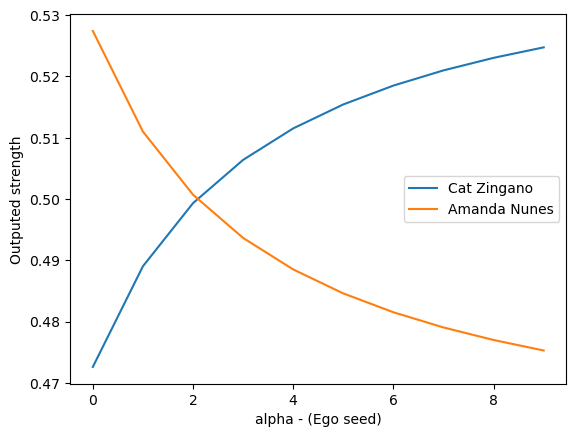

In [17]:
list_alpha = list(range(10))
df = pd.concat([compute_relativeStrength(G, list_fighters, alpha=a)[0] for a in list_alpha], axis=1)
for f in list_fighters:
    plt.plot(list_alpha, (df/df.sum(axis=0)).loc[f].values, label=f)
plt.xlabel("alpha - (Ego seed)")
plt.ylabel("Outputed strength")
plt.legend()

#### Small examples

In [18]:
list_fighters = [0,1]

*Disconnected network*

In this case, not judge can be identified because the nodes to be ranked are in different components.

,0,1,credibility
2,0.114865,0.000000,NaN
3,0.114865,0.000000,NaN
4,0.114865,0.000000,NaN
5,0.114865,0.000000,NaN
6,0.000000,0.459458,NaN
0,0.000000,0.000000,NaN
1,0.000000,0.000000,NaN


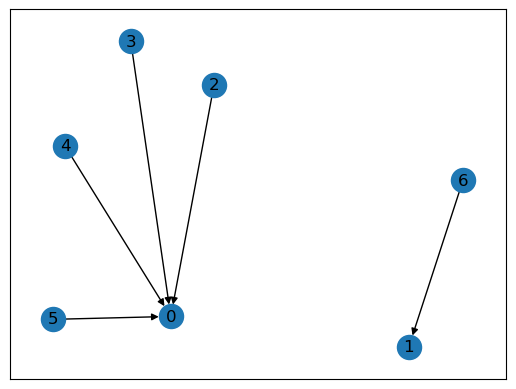

In [19]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)
display(df)
# s = get_relativeStrength(G, list_fighters)

*Strong bridge node*

Node 7 is identified as the only node able to make a judgment on the two nodes to be ranked. However, since it has won agaisnt both, it is not possible to make a decision.

,0,1,credibility
2,0.091892,0.000000,0.0
3,0.091892,0.000000,0.0
4,0.091892,0.000000,0.0
5,0.091892,0.000000,0.0
6,0.000000,0.229729,0.0
7,0.091892,0.229729,1.0
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0


Strengths :


0    0.0
1    0.0
dtype: float64

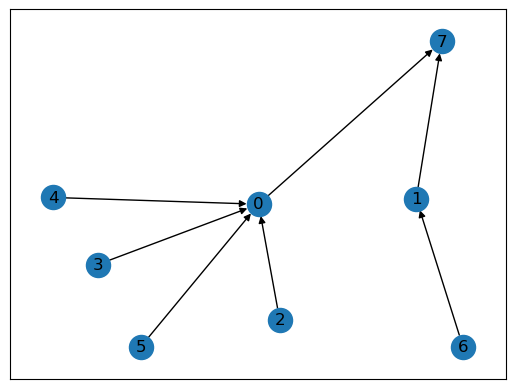

In [20]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            ,[1,7]
            ,[0,7]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters)
print("Strengths :")
display(s)

*Weak bridge node*
Same situation as before except this time the bridge give a positive strength to each node to be rank since it was beaten by both.

,0,1,credibility
2,0.091892,0.000000,0.0
3,0.091892,0.000000,0.0
4,0.091892,0.000000,0.0
5,0.091892,0.000000,0.0
6,0.000000,0.229729,0.0
7,0.091892,0.229729,1.0
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0


Strengths :


0    0.229729
1    0.229729
dtype: float64

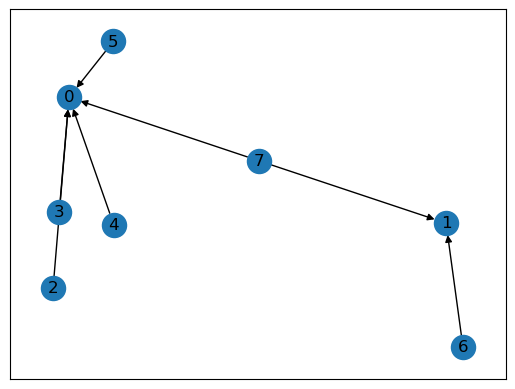

In [21]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            ,[7,1]
            ,[7,0]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters)
print("Strengths :")
display(s)

*Decisive bridge node*

A bridge node was beaten by node 1 and won against node 2. In this situation node 1 can be determined as the strongest node of the two.

,0,1,credibility
2,0.091892,0.000000,0.0
3,0.091892,0.000000,0.0
4,0.091892,0.000000,0.0
5,0.091892,0.000000,0.0
6,0.000000,0.229729,0.0
7,0.091892,0.229729,1.0
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0


Strengths :


0    0.000000
1    0.459458
dtype: float64

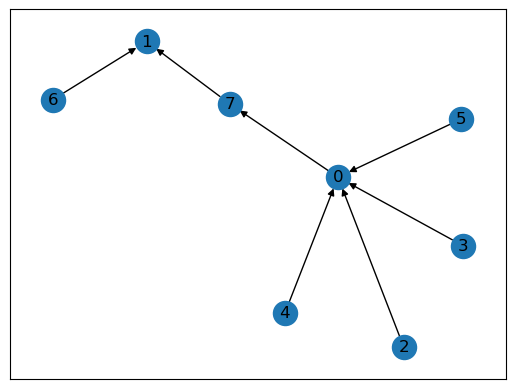

In [22]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            ,[7,1]
            ,[0,7]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters)
print("Strengths :")
display(s)

Bridge and longer bridge \
<mark>Does it work yet?</mark> : <span style="color:red"> ? add the constraint that a short bridge one way and a longer bridge the other way should be in favor of the shortest bridge. That is to say if A beats Red but is beaten by Blue it means that Blue should be stronger than Red with more confidence than if A beats Red, but is beaten by B who is beaten by Blue / Or is it true ? A chain of beaten by might just mean there is a lot more distance between the two competing nodes. </span><span style="color:blue"> the damping factor for the final pr could be a parameter than enable us to adjust our confidence in long chains </span> / <span style="color:red"> Problem with bridge 1 nodes one way and bridge 2 nodes return ? </span>

,0,1,credibility
7,0.159121,0.159121,1.000000
8,0.019966,0.209763,0.165415
9,0.046981,0.119159,0.221103
10,0.070608,0.070608,0.196906
11,0.119159,0.046981,0.221103
12,0.209763,0.019966,0.165415
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000


Strengths :


0    0.008668
1    0.045773
dtype: float64

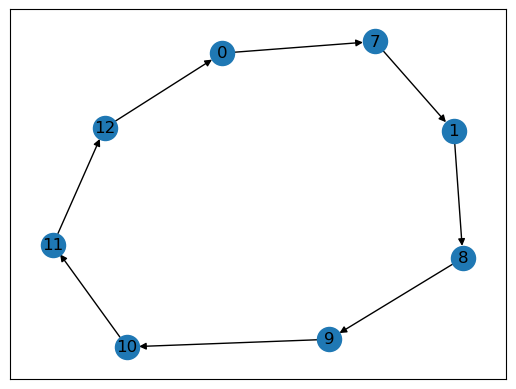

In [23]:
list_edge = (
            [7,1]
            ,[0,7]
            ,[1,8]
            ,[8,9]
            ,[9,10]
            ,[10,11]
            ,[11,12]
            ,[12,0]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters, damping_factor=0.1)
print("Strengths :")
display(s)

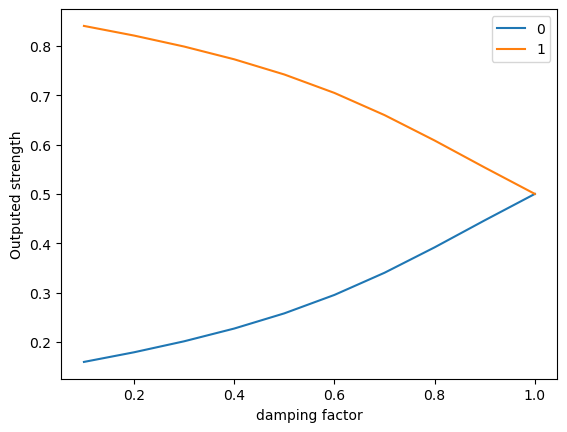

In [24]:
list_edge = (
            [7,1]
            ,[0,7]
            ,[1,8]
            ,[8,9]
            ,[9,10]
            ,[10,11]
            ,[11,12]
            ,[12,0]
            )
G = nx.DiGraph(list_edge)
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA)
G = add_credibilityToNetwork(df, G)

list_final_pr_damping = np.linspace(0,1,11)
df = pd.concat([get_relativeStrength(G, list_fighters, damping_factor=a) for a in list_final_pr_damping], axis=1)
for f in list_fighters:
    plt.plot(list_final_pr_damping, (df/df.sum(axis=0)).loc[f].values, label=f)
plt.xlabel("damping factor")
plt.ylabel("Outputed strength")
plt.legend()

#### Presentation example

In [170]:
list_edge = (
            [12,4]
            ,[2,4]
            ,[2,0]
            ,[3,12]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,0]
            ,[6,3]
            ,[0,7]
            ,[0,8]
            ,[7,9]
            ,[8,1]
            ,[9,1]
            ,[10,1]
            ,[11,10]
            ,[11,1]
            # ,[7,6]  # connects the two clusters
            )
G = nx.DiGraph(list_edge)

pos = nx.spring_layout(G.subgraph(set(G)))  # initialisation of position dict

pos[0] = [0,0]
pos[1] = [1,0]
pos[12] = [-0.5,0]
pos[2] = [-0.4, -0.25]
pos[3] = [-0.4, 0.25]
pos[4] = [-0.25, 0]
pos[5] = [-0.25, -.35]
pos[6] = [-0.15, 0.25]
pos[7] = [0.25, 0.15]
pos[8] = [0.25, -0.15]
pos[9] = [0.75, 0]
pos[10] = [1.15, -0.15]
pos[11] = [1.15, 0.15]

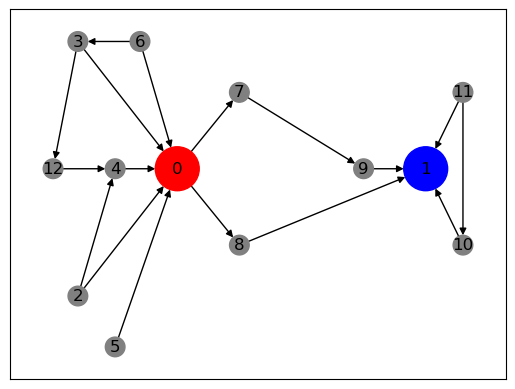

In [171]:
color_map = ['Red' if node == 0 else 'Blue' if node==1 else "gray" for node in G] 
nx.draw_networkx(G
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color=color_map)

In [172]:
df = compute_judgesCredibility(G, list_fighters, alpha=ALPHA, credibility_damping_factor=0.5)

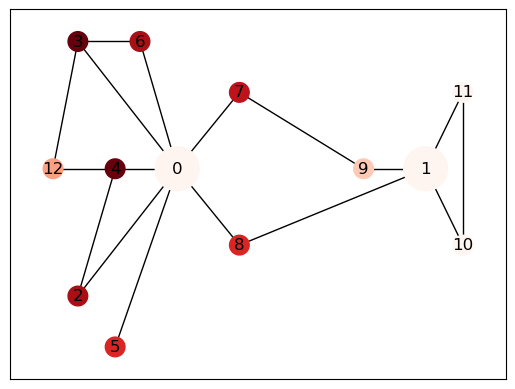

In [173]:
nx.draw_networkx(G.to_undirected()
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color= df.loc[list(G.nodes), 0].values
                 ,cmap=plt.get_cmap('Reds')
                 )

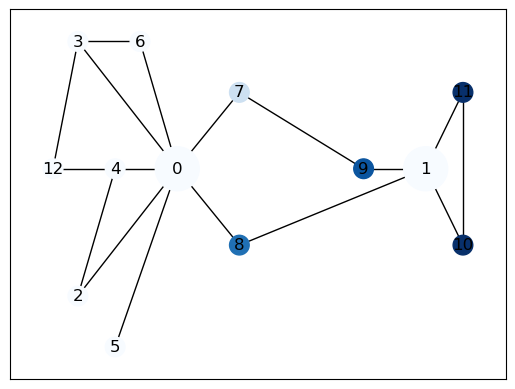

In [174]:
nx.draw_networkx(G.to_undirected()
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color= df.loc[list(G.nodes), 1].values
                 ,cmap=plt.get_cmap('Blues')
                 )

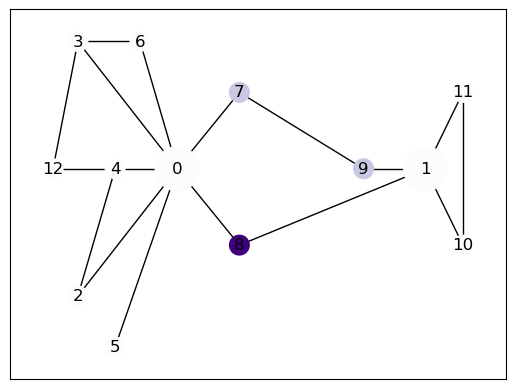

In [175]:
nx.draw_networkx(G.to_undirected()
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color= df.loc[list(G.nodes), "credibility"].values
                 ,cmap=plt.get_cmap('Purples')
                 )

### Walk Index

## Ranking comparison

# <>

1. Récupérer tous les paths entre 0 et 1
2. Décomposer les paths pour avoir les paths non plus entre 0 et 1 mais entre 0 et tous les noeuds distincts rencontrés et 1 et tous les noeuds distincts rencontrés
3. Compter pour chaque noeud rencontré le nombre de chemin de longueur l à 0 et à 1

In [206]:
df_preprocessed = preprocess_df_fights(df_fights)
G = create_contactNetwork(df_preprocessed)

In [207]:
fighter0 = "Leon Edwards"
fighter1 = "Kamaru Usman"
list_path = list(nx.all_simple_paths(G, fighter0, fighter1, cutoff=5))

In [208]:
list_split0 = []
list_split1 = []
for l in list_path:
    n = len(l)
    for i in range(1, n-1):
        sublist0 = l[:i+1]
        sublist1 = l[i:]
        if sublist0 not in list_split0:
            list_split0.append(sublist0)
        if sublist1 not in list_split1:
            list_split1.append(sublist1)

In [212]:
list_split1

[['Belal Muhammad',
  'Geoff Neal',
  'Stephen Thompson',
  'Tyron Woodley',
  'Kamaru Usman'],
 ['Geoff Neal', 'Stephen Thompson', 'Tyron Woodley', 'Kamaru Usman'],
 ['Stephen Thompson', 'Tyron Woodley', 'Kamaru Usman'],
 ['Tyron Woodley', 'Kamaru Usman'],
 ['Belal Muhammad',
  'Vicente Luque',
  'Stephen Thompson',
  'Tyron Woodley',
  'Kamaru Usman'],
 ['Vicente Luque', 'Stephen Thompson', 'Tyron Woodley', 'Kamaru Usman'],
 ['Belal Muhammad',
  'Alan Jouban',
  'Gunnar Nelson',
  'Gilbert Burns',
  'Kamaru Usman'],
 ['Alan Jouban', 'Gunnar Nelson', 'Gilbert Burns', 'Kamaru Usman'],
 ['Gunnar Nelson', 'Gilbert Burns', 'Kamaru Usman'],
 ['Gilbert Burns', 'Kamaru Usman'],
 ['Belal Muhammad',
  'Alan Jouban',
  'Gunnar Nelson',
  'Demian Maia',
  'Kamaru Usman'],
 ['Alan Jouban', 'Gunnar Nelson', 'Demian Maia', 'Kamaru Usman'],
 ['Gunnar Nelson', 'Demian Maia', 'Kamaru Usman'],
 ['Demian Maia', 'Kamaru Usman'],
 ['Belal Muhammad', 'Alan Jouban', 'Warlley Alves', 'Kamaru Usman'],
 ['Alan

In [183]:
d0 = {}
d1 = {}
for l in list_path:
    n = len(l)
    for i in range(1, n-1):
        if l[i] in d0:
            d0[l[i]].append(i)
            d1[l[i]].append(n-i)
        else:
            d0[l[i]] = []
            d1[l[i]] = []